In [32]:
from os.path import join as opj
import os
import json
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.fsl import (BET, ExtractROI, FAST, FLIRT, ImageMaths,
                                   MCFLIRT, SliceTimer, Threshold)
# https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FslOverview
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.pipeline.engine import Workflow, Node

%matplotlib inline
from nilearn import image, plotting
from samri.pipelines import nodes

In [33]:
exp_dir = '/oak/stanford/groups/ljinhy/sandbox/people/charles/final_work'
input_dir = 'data/rodent/Mouse_BOLD'
working_dir = 'intermediate'
output_dir = 'output'
iso_size = 4
TR = 2.5 #resampling repetition time

In [34]:
# Input specification
# list of subject identifiers, a file is organized as (example):
#  ${exp_dir}/${input_dir}/sub-01/anat.nii.gz
subject_list = ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05',
                'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10']
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = opj('{subject_id}', 'anat.nii.gz')
func_file = opj('{subject_id}', 'func.nii.gz')

templates = {'anat': anat_file,
             'func': func_file}
selectfiles = Node(SelectFiles(templates,
                               base_directory=opj(exp_dir, input_dir)),
                   name="selectfiles")

In [35]:
# ExtractROI - control time and space limits to the ROI. Using FSL function "fslroi" in "Fslutils"
extract = Node(ExtractROI(), output_type='NIFTI', name="extract")
extract.interface.load_inputs_from_json('param_extract.json', overwrite=False)
#extract.interface.inputs.t_min=4
#extract.interface.inputs.t_size=-1
#extract.interface.save_inputs_to_json('param_extract.json')

In [36]:
# MCFLIRT - motion correction
mcflirt = Node(MCFLIRT(), name="mcflirt")
mcflirt.interface.load_inputs_from_json('param_mcflirt.json', overwrite=False)
#mcflirt.interface.inputs.mean_vol=True
#mcflirt.interface.inputs.save_plots=True
#mcflirt.interface.inputs.output_type = 'NIFTI_GZ'
#mcflirt.interface.save_inputs_to_json('param_mcflirt.json')

In [37]:
# SliceTimer - correct for slice wise acquisition, interpolate and resample
slicetimer = Node(SliceTimer(), name="slicetimer")
slicetimer.interface.load_inputs_from_json('param_slicetimer.json', overwrite=False)
#slicetimer.interface.inputs.index_dir=False
#slicetimer.interface.inputs.interleaved=True
#slicetimer.interface.inputs.time_repetition=TR
#slicetimer.interface.inputs.output_type ='NIFTI_GZ'
slicetimer.interface.save_inputs_to_json('param_slicetimer.json')

In [38]:
# BET - Skullstrip anatomical Image
bet_anat = Node(BET(), name="bet_anat")
bet_anat.interface.load_inputs_from_json('param_bet_anat.json', overwrite=False)
#bet_anat.interface.inputs.frac = 0.5
#bet_anat.interface.inputs.robust = True
#bet_anat.interface.inputs.output_type = 'NIFTI_GZ'
#bet_anat.interface.save_inputs_to_json('param_bet_anat.json')

In [39]:
# FAST - Image Segmentation
segmentation = Node(FAST(output_type='NIFTI_GZ'),
                name="segmentation")
# Select WM segmentation file from segmentation output
def get_wm(files):
    return files[-1]


# Threshold - Threshold WM probability image
threshold = Node(Threshold(), name="threshold")
threshold.interface.load_inputs_from_json('param_threshold.json', overwrite=False)
#threshold.interface.inputs.thresh = 0.5
#threshold.interface.inputs.args = '-bin'
#threshold.interface.inputs.output_type = 'NIFTI_GZ'
#threshold.interface.save_inputs_to_json('param_threshold.json')

In [40]:
# FLIRT - pre-alignment of functional images to anatomical images
coreg_pre = Node(FLIRT(), name="coreg_pre")
coreg_pre.interface.load_inputs_from_json('param_coreg_pre.json', overwrite=False)
#coreg_pre.interface.inputs.dof = 6
#coreg_pre.interface.inputs.output_type = 'NIFTI_GZ'
#coreg_pre.interface.save_inputs_to_json('param_coreg_pre.json')


# FLIRT - coregistration of functional images to anatomical images with BBR
coreg_bbr = Node(FLIRT(), name="coreg_bbr")
coreg_bbr.interface.load_inputs_from_json('param_coreg_bbr.json', overwrite=False)
#coreg_bbr.interface.inputs.dof = 6
#coreg_bbr.interface.inputs.cost = 'bbr'
#coreg_bbr.interface.inputs.schedule = opj(os.getenv('FSLDIR'),'etc/flirtsch/bbr.sch')
#coreg_bbr.interface.inputs.output_type = 'NIFTI_GZ'
#coreg_bbr.interface.save_inputs_to_json('param_coreg_bbr.json')

In [41]:
# Apply coregistration warp to functional images
applywarp = Node(FLIRT(), name="applywarp")
applywarp.interface.load_inputs_from_json('param_applywarp.json', overwrite=False)
#applywarp.interface.inputs.interp = 'spline'
#applywarp.interface.inputs.apply_isoxfm = iso_size
#applywarp.interface.inputs.output_type = 'NIFTI_GZ'
#applywarp.interface.save_inputs_to_json('param_applywarp.json')


# Apply coregistration warp to mean file
applywarp_mean = Node(FLIRT(), name="applywarp_mean")
applywarp_mean.interface.load_inputs_from_json('param_applywarp.json', overwrite=False)
#applywarp_mean.interface.inputs.interp = 'spline'
#applywarp_mean.interface.inputs.apply_isoxfm = iso_size
#applywarp_mean.interface.inputs.output_type = 'NIFTI_GZ'
#applywarp_mean.interface.save_inputs_to_json('param_applywarp_mean.json')

In [42]:
# Create a coregistration workflow
coregwf = Workflow(name='coregwf')
coregwf.base_dir = opj(exp_dir, working_dir)

# Connect all components of the coregistration workflow
coregwf.connect([(bet_anat, segmentation, [('out_file', 'in_files')]),
                 (segmentation, threshold, [(('partial_volume_files', get_wm), 'in_file')]),
                 (bet_anat, coreg_pre, [('out_file', 'reference')]),
                 (threshold, coreg_bbr, [('out_file', 'wm_seg')]),
                 (coreg_pre, coreg_bbr, [('out_matrix_file', 'in_matrix_file')]),
                 (coreg_bbr, applywarp, [('out_matrix_file', 'in_matrix_file')]),
                 (bet_anat, applywarp, [('out_file', 'reference')]),
                 (coreg_bbr, applywarp_mean, [('out_matrix_file', 'in_matrix_file')]),
                 (bet_anat, applywarp_mean, [('out_file', 'reference')]),
                 ])

In [43]:
input_func = opj(exp_dir, input_dir, 'M01/RS1.nii.gz')
input_anat = opj(exp_dir, input_dir, 'M01/T2.nii.gz')

mcflirt.inputs.in_file = input_func
coregwf.inputs.bet_anat.in_file = input_anat
coregwf.inputs.coreg_bbr.reference = input_anat
mcflirt.inputs.out_file = opj(exp_dir, output_dir, 'mcflirt_out.nii.gz')
coregwf.outputs.applywarp.out_file = opj(exp_dir, output_dir, 'coregwf.nii.gz')
coregwf.outputs.applywarp_mean.out_file = opj(exp_dir, output_dir, 'coregwf_mean.nii.gz')

In [44]:
#ANTs registration across mouse subject using SAMRI
from samri.pipelines import nodes
[ants_reg, s_warp, f_warp] = nodes.structural_registration(template = opj(exp_dir, input_dir, 'M02/T2.nii.gz'))
#for rats: nodes.DSURQEc_structural_registration
#ants_reg.inputs.output_warped_image = opj(exp_dir, output_dir, 'ants_reg_out.nii.gz')
#ants_reg.interface.save_inputs_to_json('param_ants_reg.json')
ants_reg.interface.load_inputs_from_json('param_ants_reg.json', overwrite=False)

In [45]:
# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=exp_dir,
                         container=opj(exp_dir, output_dir)),
                name="datasink")

## Use the following DataSink output substitutions
substitutions = [('_subject_id_', ''),
                 ('_roi', ''),
                 ('_mcf', ''),
                 ('_st', ''),
                 ('_flirt', ''),
                 ('.nii_mean_reg', '_mean'),
                 ('.nii.par', '.par'),
                 ]
datasink.inputs.substitutions = substitutions

In [46]:
# Create a preprocessing workflow
preproc = Workflow(name='preproc')
preproc.base_dir = opj(exp_dir, working_dir)

# Connect all components of the preprocessing workflow
preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id')]),
                 (selectfiles, extract, [('func', 'in_file')]),
                 (extract, mcflirt, [('roi_file', 'in_file')]),
                 (mcflirt, slicetimer, [('out_file', 'in_file')]),
                 (selectfiles, coregwf, [('anat', 'bet_anat.in_file'),
                                         ('anat', 'coreg_bbr.reference')]),
                 (mcflirt, coregwf, [('mean_img', 'coreg_pre.in_file'),
                                     ('mean_img', 'coreg_bbr.in_file'),
                                     ('mean_img', 'applywarp_mean.in_file')]),
                 (slicetimer, coregwf, [('slice_time_corrected_file', 'applywarp.in_file')]),
                 (coregwf, ants_reg, [('bet_anat.out_file', 'moving_image')]),
                 (mcflirt, datasink, [('par_file', 'preproc.@par')]),
                 (coregwf, datasink, [('applywarp_mean.out_file', 'preproc.@mean'),
                                      ('coreg_bbr.out_matrix_file', 'preproc.@mat_file'),
                                      ('bet_anat.out_file', 'preproc.@brain')]),
                 (ants_reg, datasink, [('warped_image', 'preproc.@ants')]),
                 ])

180109-02:51:19,638 workflow INFO:
	 Generated workflow graph: /oak/stanford/groups/ljinhy/sandbox/people/charles/final_work/intermediate/preproc/graph.dot.svg (graph2use=colored, simple_form=True).


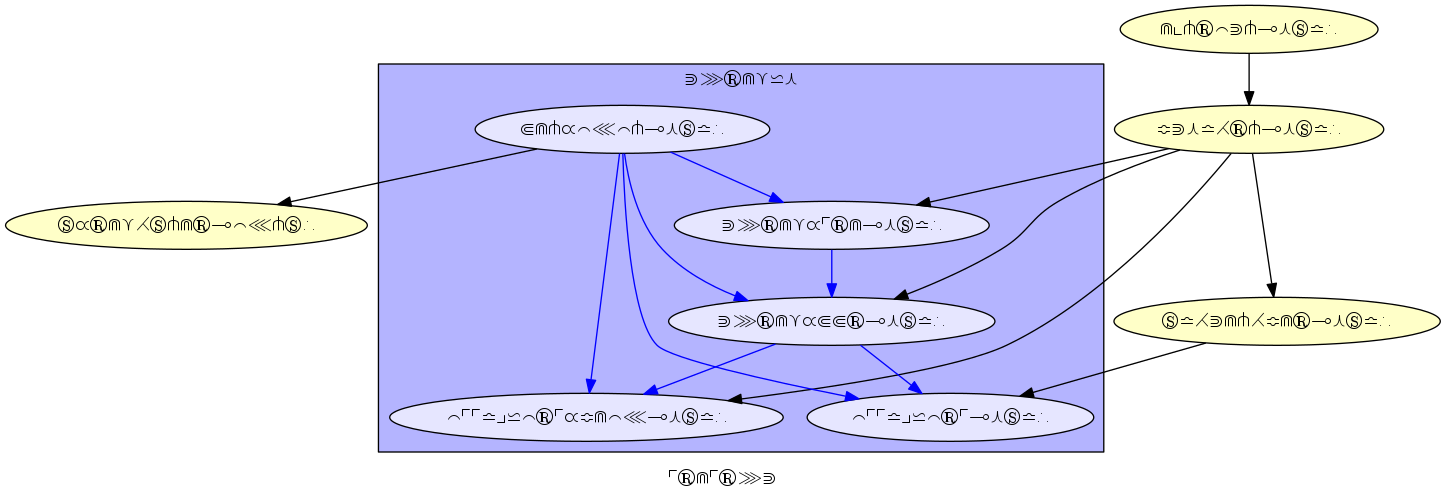

In [47]:
# Create preproc output graph
preproc.write_graph(graph2use='colored', format='svg', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(preproc.base_dir, 'preproc', 'graph.dot.png'))

In [48]:
preproc.run('MultiProc', plugin_args={'n_procs': 4})

180109-02:51:22,445 workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging']
180109-02:51:22,862 workflow INFO:
	 Running in parallel.
180109-02:51:22,874 workflow INFO:
	 Executing: selectfiles.a9 ID: 0
180109-02:51:22,881 workflow INFO:
	 Executing: selectfiles.a8 ID: 13
180109-02:51:22,978 workflow INFO:
	 Executing: selectfiles.a7 ID: 26
180109-02:51:22,991 workflow INFO:
	 Executing: selectfiles.a6 ID: 39
180109-02:51:22,973 workflow INFO:
	 Executing node selectfiles.a9 in dir: /oak/stanford/groups/ljinhy/sandbox/people/charles/final_work/intermediate/preproc/_subject_id_sub-10/selectfiles180109-02:51:22,995 workflow INFO:
	 Executing node selectfiles.a7 in dir: /oak/stanford/groups/ljinhy/sandbox/people/charles/final_work/intermediate/preproc/_subject_id_sub-08/selectfiles180109-02:51:22,981 workflow INFO:
	 Executing node selectfiles.a8 in dir: /oak/stanford/groups/ljinhy/sandbox/people/charles/final_work/intermediate/preproc/_subject_id_sub-09/selectfiles1

180109-02:51:23,574 workflow INFO:
	 Executing: selectfiles.a4 ID: 65
180109-02:51:23,580 workflow INFO:
	 Executing: selectfiles.a3 ID: 78
180109-02:51:23,581 workflow INFO:
	 Executing node selectfiles.a4 in dir: /oak/stanford/groups/ljinhy/sandbox/people/charles/final_work/intermediate/preproc/_subject_id_sub-05/selectfiles
180109-02:51:23,591 workflow INFO:
	 Executing: selectfiles.a2 ID: 91
180109-02:51:23,592 workflow INFO:
	 Executing node selectfiles.a3 in dir: /oak/stanford/groups/ljinhy/sandbox/people/charles/final_work/intermediate/preproc/_subject_id_sub-04/selectfiles180109-02:51:23,598 workflow ERROR:
	 ['Node selectfiles.a5 failed to run on host sh-112-12.int.']
180109-02:51:23,603 workflow INFO:
	 Saving crash info to /oak/stanford/groups/ljinhy/sandbox/people/charles/final_work/Pipeline/crash-20180109-025123-zcchen-selectfiles.a5-fb16892e-59fa-4b70-8ab3-d731b1ea21b2.pklz
180109-02:51:23,604 workflow INFO:
	 Traceback (most recent call last):
  File "/oak/stanford/group

180109-02:51:23,695 workflow INFO:
	 Executing node selectfiles.a0 in dir: /oak/stanford/groups/ljinhy/sandbox/people/charles/final_work/intermediate/preproc/_subject_id_sub-01/selectfiles
180109-02:51:23,764 workflow ERROR:
	 ['Node selectfiles.a1 failed to run on host sh-112-12.int.']
180109-02:51:23,766 workflow INFO:
	 Saving crash info to /oak/stanford/groups/ljinhy/sandbox/people/charles/final_work/Pipeline/crash-20180109-025123-zcchen-selectfiles.a1-414ed62a-5242-40fb-b8ff-d10b170895cb.pklz
180109-02:51:23,767 workflow INFO:
	 Traceback (most recent call last):
  File "/oak/stanford/groups/ljinhy/it/anaconda3/envs/jinni/lib/python3.6/site-packages/nipype/pipeline/plugins/multiproc.py", line 52, in run_node
    result['result'] = node.run(updatehash=updatehash)
  File "/oak/stanford/groups/ljinhy/it/anaconda3/envs/jinni/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 372, in run
    self._run_interface()
  File "/oak/stanford/groups/ljinhy/it/anaconda3/envs/jin

RuntimeError: Workflow did not execute cleanly. Check log for details